PAC. Pràctica 2. Tipologia i cicle de vida de les dades. Universitat Oberta de Catalunya.

J. de Curtò i DíAz & I. de Zarzà i Cubero. decurto@uoc.edu dezarza@uoc.edu

Example of instance segmentation using Deeplab with a sample from NASA Perseverance (DrCyZ).

Adapt folder paths accordingly. Data is available at:

CyZ: MARS Space Exploration Dataset.

https://github.com/decurtoidiaz/cyz

DrCyZ: Techniques for analyzing and extracting useful information from CyZ.

https://github.com/decurtoidiaz/drcyz

c@decurto.be z@dezarza.be

Original source code from:

https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/DeepLabV3/DeepLab_TFLite_ADE20k.ipynb

adapted and modified by De Curtò i DíAz & De Zarzà i Cubero.

## Setup

In [ ]:
import os
import tempfile
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.7.0


## Loading the model files

In [ ]:
#@title Downloading and extracting the model checkpoints

MODEL_NAME = 'deeplabv3_mnv2_ade20k_train_2018_12_03'  # @param ['deeplabv3_mnv2_ade20k_train_2018_12_03', 'deeplabv3_xception_ade20k_train']

DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
MODEL_URLS = {
    'deeplabv3_mnv2_ade20k_train_2018_12_03':
        'deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz',
    'deeplabv3_xception_ade20k_train':
        'deeplabv3_xception_ade20k_train_2018_05_29.tar.gz',
}

MODEL_TAR = MODEL_URLS[MODEL_NAME]
MODEL_URL = DOWNLOAD_URL_PREFIX + MODEL_TAR

# Download
!wget -O {MODEL_TAR} {MODEL_URL}

# Extract
MODEL_FILE = !tar -zxvf {MODEL_TAR} --wildcards --no-anchored 'frozen_inference_graph.pb'
MODEL_FILE = MODEL_FILE[0].strip()
print('Frozen graph file path:', MODEL_FILE)

--2021-12-26 15:52:55--  http://download.tensorflow.org/models/deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26028742 (25M) [application/x-tar]
Saving to: ‘deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz’

deeplabv3_mnv2_ade2 100%[===================>]  24.82M  --.-KB/s    in 0.1s    

2021-12-26 15:52:56 (166 MB/s) - ‘deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz’ saved [26028742/26028742]

Frozen graph file path: deeplabv3_mnv2_ade20k_train_2018_12_03/frozen_inference_graph.pb


## Convert to TFLite

In [ ]:
# Load the TensorFlow model
# The preprocessing and the post-processing steps should not be included in the TF Lite model graph 
# because some operations (ArgMax) might not support the delegates. 
# Insepct the graph using Netron https://lutzroeder.github.io/netron/
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file = MODEL_FILE, 
    input_arrays = ['sub_7'], 
    output_arrays = ['ResizeBilinear_2']
)

# Optional: Perform the simplest optimization known as post-training dynamic range quantization.
# https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization
# You can refer to the same document for other types of optimizations.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert to TFLite Model
tflite_model = converter.convert()

_, tflite_path = tempfile.mkstemp('.tflite')
tflite_model_size = open(tflite_path, 'wb').write(tflite_model)
tf_model_size = os.path.getsize(MODEL_FILE)
print('TensorFlow Model is  {} bytes'.format(tf_model_size))
print('TFLite Model is      {} bytes'.format(tflite_model_size))
print('Post training dynamic range quantization saves {} bytes'.format(tf_model_size-tflite_model_size))

TensorFlow Model is  9559095 bytes
TFLite Model is      2744256 bytes
Post training dynamic range quantization saves 6814839 bytes


In [ ]:
!ls -lh {tflite_path}

-rw------- 1 root root 2.7M Dec 26 15:52 /tmp/tmpga_p4765.tflite


## Inference using TFLite model

### 1. Get Input Image Size

In [ ]:
# Load the model.
interpreter = tf.lite.Interpreter(model_path=tflite_path)

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# get image size - converting from BHWC to WH
input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]
print(input_size)

(513, 513)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


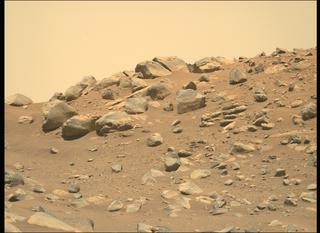

In [ ]:
#@title 2. Provide a URL to your image to download
from google.colab import drive
drive.mount('/content/drive')
#!unzip '/content/drive/MyDrive/Colab Notebooks/segmentation_dr_cyz.zip'

#url = '/content/segmentation/ZL0_0136_0679011873_443EBY_N0051388ZCAM08142_1100LMJ06_320.png'
url = '/content/segmentation/ZL0_0136_0679011910_410EBY_N0051388ZCAM08142_1100LMJ04_320.png'
#url = '/content/segmentation/ZL0_0136_0679011885_409EBY_N0051388ZCAM08142_1100LMJ03_320.png'
#url = '/content/segmentation/ZL0_0136_0679011898_409EBY_N0051388ZCAM08142_1100LMJ03_320.png'
#IMAGE_URL = 'https://mars.nasa.gov/mars2020-raw-images/pub/ods/surface/sol/00009/ids/edr/browse/ncam/NRF_0009_0667755636_926EBY_N0030000NCAM05000_06_0LLJ01.png'
#IMAGE_URL = 'https://www.dea5.net/wp-content/uploads/modular-kitchen.jpg' #@param {type:"string"}
#!wget -O image {IMAGE_URL}

from PIL import Image
#image = Image.open('image')
image = Image.open(url)
image

#### Prepare the downloaded image for running inference

(233, 233) (320, 233)


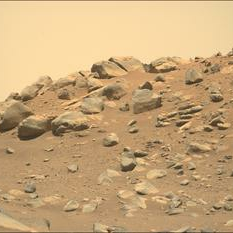

In [ ]:
from PIL import ImageOps

old_size = image.size  # old_size is in (width, height) format
desired_ratio = input_size[0] / input_size[1]
old_ratio = old_size[0] / old_size[1]

if old_ratio < desired_ratio: # '<': cropping, '>': padding
    new_size = (old_size[0], int(old_size[0] / desired_ratio))
else:
    new_size = (int(old_size[1] * desired_ratio), old_size[1])

print(new_size, old_size)

# Cropping the original image to the desired aspect ratio
delta_w = new_size[0] - old_size[0]
delta_h = new_size[1] - old_size[1]
padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
cropped_image = ImageOps.expand(image, padding)
cropped_image

In [ ]:
# Resize the cropped image to the desired model size
resized_image = cropped_image.convert('RGB').resize(input_size, Image.BILINEAR)

# Convert to a NumPy array, add a batch dimension, and normalize the image.
image_for_prediction = np.asarray(resized_image).astype(np.float32)
image_for_prediction = np.expand_dims(image_for_prediction, 0)
image_for_prediction = image_for_prediction / 127.5 - 1
image_for_prediction

array([[[[ 0.28627455,  0.05882359, -0.2862745 ],
         [ 0.28627455,  0.05882359, -0.2862745 ],
         [ 0.28627455,  0.05882359, -0.2862745 ],
         ...,
         [ 0.21568632,  0.02745104, -0.31764704],
         [ 0.21568632,  0.02745104, -0.31764704],
         [ 0.21568632,  0.02745104, -0.31764704]],

        [[ 0.4039216 ,  0.17647064, -0.16862744],
         [ 0.4039216 ,  0.17647064, -0.16862744],
         [ 0.4039216 ,  0.17647064, -0.16862744],
         ...,
         [ 0.33333337,  0.14509809, -0.19999999],
         [ 0.33333337,  0.14509809, -0.19999999],
         [ 0.33333337,  0.14509809, -0.19999999]],

        [[ 0.7019608 ,  0.47450984,  0.12941182],
         [ 0.7019608 ,  0.47450984,  0.12941182],
         [ 0.7019608 ,  0.47450984,  0.12941182],
         ...,
         [ 0.6313726 ,  0.4431373 ,  0.09803927],
         [ 0.6313726 ,  0.4431373 ,  0.09803927],
         [ 0.6313726 ,  0.4431373 ,  0.09803927]],

        ...,

        [[ 0.23921573,  0.04313731, -0

Thanks to Khanh for helping to figure out the pre-processing and post-processing code.

### 3. Run Inference

In [ ]:
# Load the model.
interpreter = tf.lite.Interpreter(model_path=tflite_path)

# Invoke the interpreter to run inference.
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], image_for_prediction)
interpreter.invoke()

# Retrieve the raw output map.
raw_prediction = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

# Post-processing: convert raw output to segmentation output
## Method 1: argmax before resize - this is used in some frozen graph
seg_map = np.squeeze(np.argmax(raw_prediction, axis=3)).astype(np.int8)
seg_map = np.asarray(Image.fromarray(seg_map).resize(image.size, resample=Image.NEAREST))
## Method 2: resize then argmax - this is used in some other frozen graph and produce smoother output
#width, height = cropped_image.size
#seg_map = tf.argmax(tf.image.resize(raw_prediction, (height, width)), axis=3)
#seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)

In [ ]:
!wget https://raw.githubusercontent.com/CSAILVision/sceneparsing/master/objectInfo150.csv
import pandas as pd

ade20k_labels_info = pd.read_csv('objectInfo150.csv')
labels_list = list(ade20k_labels_info['Name'])
ade20k_labels_info.head()

--2021-12-26 16:09:44--  https://raw.githubusercontent.com/CSAILVision/sceneparsing/master/objectInfo150.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5803 (5.7K) [text/plain]
Saving to: ‘objectInfo150.csv.6’

objectInfo150.csv.6 100%[===================>]   5.67K  --.-KB/s    in 0s      

2021-12-26 16:09:44 (78.0 MB/s) - ‘objectInfo150.csv.6’ saved [5803/5803]



,Idx,Ratio,Train,Val,Stuff,Name
0,1,0.1576,11664,1172,1,wall
1,2,0.1072,6046,612,1,building;edifice
2,3,0.0878,8265,796,1,sky
3,4,0.0621,9336,917,1,floor;flooring
4,5,0.0480,6678,641,0,tree


In [ ]:
labels_list.insert(0, 'others')
len(labels_list)

151

The following code comes from https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb. However, the colormap function has been modified as shown here: https://github.com/tensorflow/models/blob/master/research/deeplab/utils/get_dataset_colormap.py#L51.

In [ ]:
#@title
from matplotlib import gridspec
from matplotlib import pyplot as plt

def create_ade20k_label_colormap():
  """Creates a label colormap used in ADE20K segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_ade20k_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/segmentation_perseverance_cyz+.png')
  plt.show()


LABEL_NAMES = np.asarray(labels_list)

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

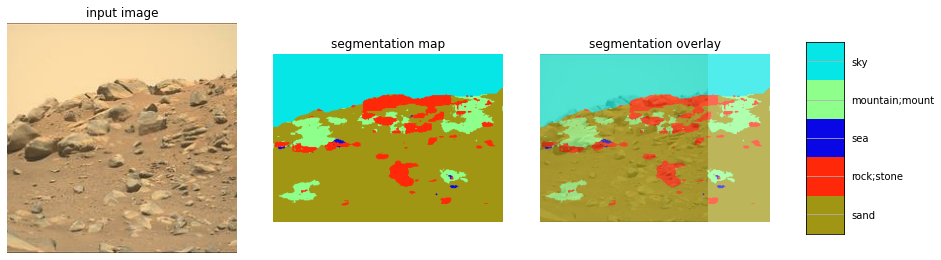

In [ ]:
vis_segmentation(cropped_image, seg_map)

To try out a new model it's advisable to Factory Reset the runtime and then trying it.